## Grid Search all Parameters

In [12]:
import sys
sys.path.append('../src')

import importlib
import dyn_accept_loop as dal
importlib.reload(dal)
import reject_inference as rinf
importlib.reload(rinf)
import helper as h
importlib.reload(h)

import matplotlib.pyplot as plt

import lightgbm as lgbm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import torch

import numpy as np

import lightgbm as lgbm

import pickle
import timeit

In [8]:
import autoencoder as aenc
import var_autoencoder as vaenc
import importlib
importlib.reload(aenc)
importlib.reload(vaenc)

from IPython import display

#### Get Baseline for all tests

In [14]:
n_years = 20
model = lgbm.LGBMClassifier(random_state=1234) # DecisionTreeClassifier(min_samples_leaf=40) LogisticRegression(max_iter=400)
datasetname = "gmsc.csv"

## ------------------------------------------------------------
## Get a Baseline Bias Measue without any reject inference
## ------------------------------------------------------------

sim = dal.Simulate_acceptance_loop(datasetname, model, 0.1, 0.1, n_years, enc_features=False, rej_inf=None)
results_generator = sim.run()

metrics = None
for iteration in results_generator:
    #print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
    metrics = iteration[3]

last_n_years = 5
baseline_bias = h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics["model"]["holdout"]['roc_auc'], last_n_years)
baseline_roc_auc = sum(metrics["model"]["holdout"]['roc_auc'][-last_n_years:]) / last_n_years
print(f'Baseline Sampling Bias: {round(baseline_bias, 5)}\nBaseline ROC-AUC: {round(baseline_roc_auc, 5)}')

Baseline Sampling Bias: 0.02411
Baseline ROC-AUC: 0.83862


#### Loop

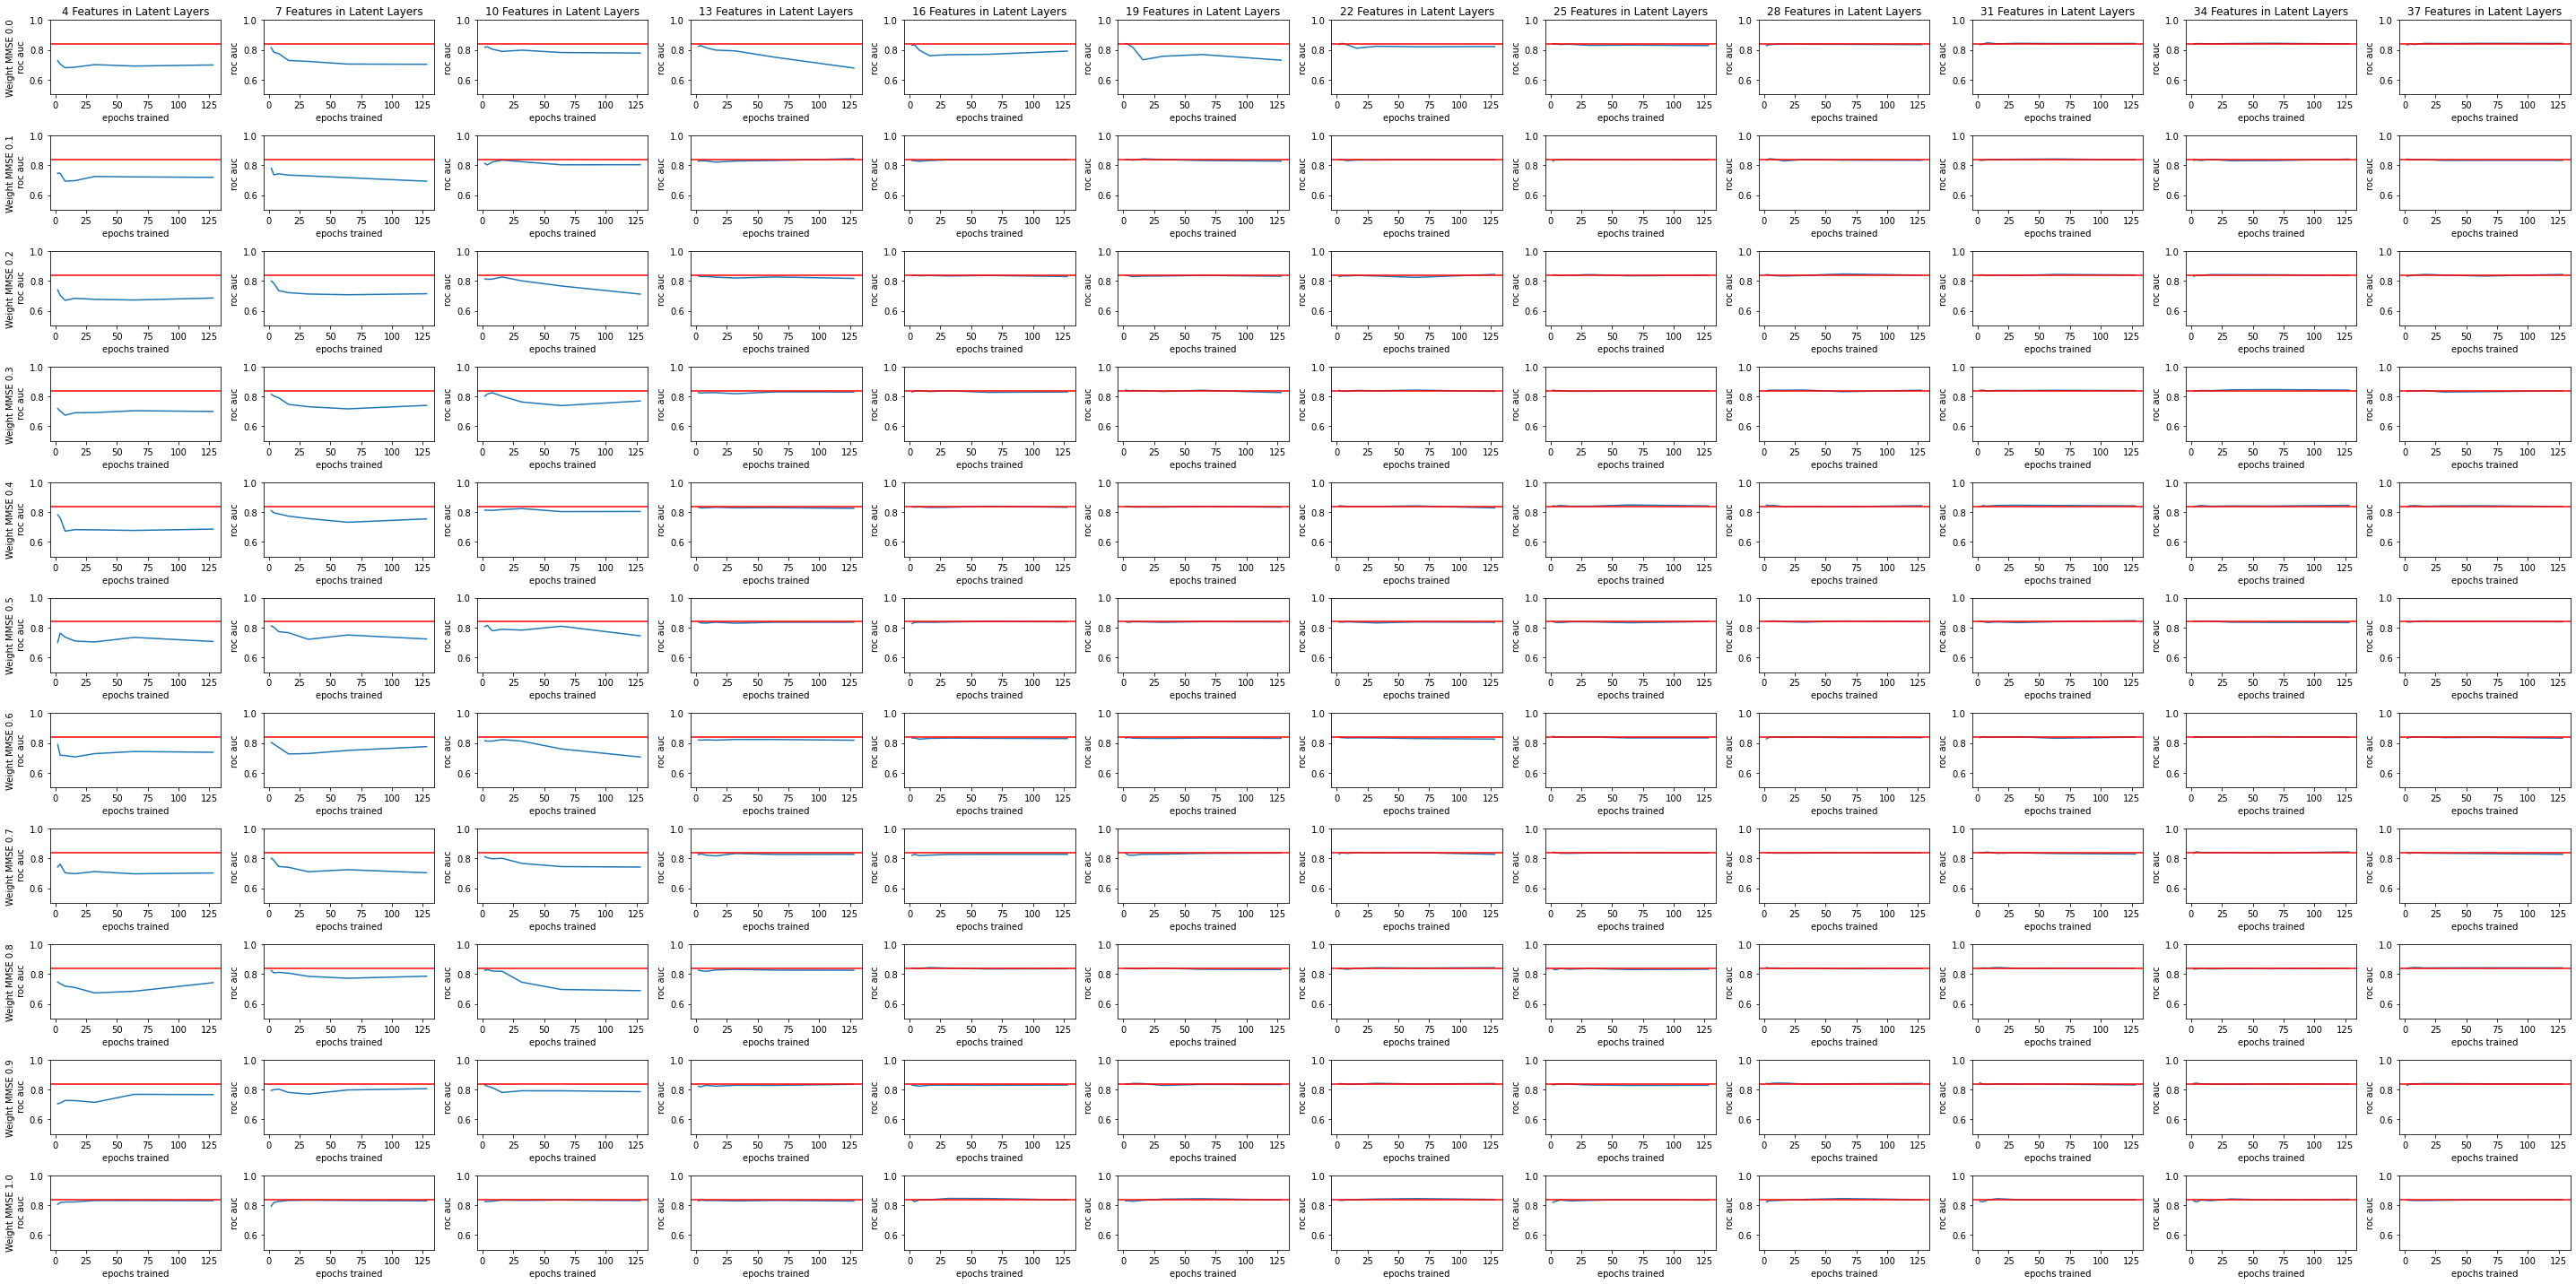

Saving current results... - Last iteration took 215.73655707099897 sec.


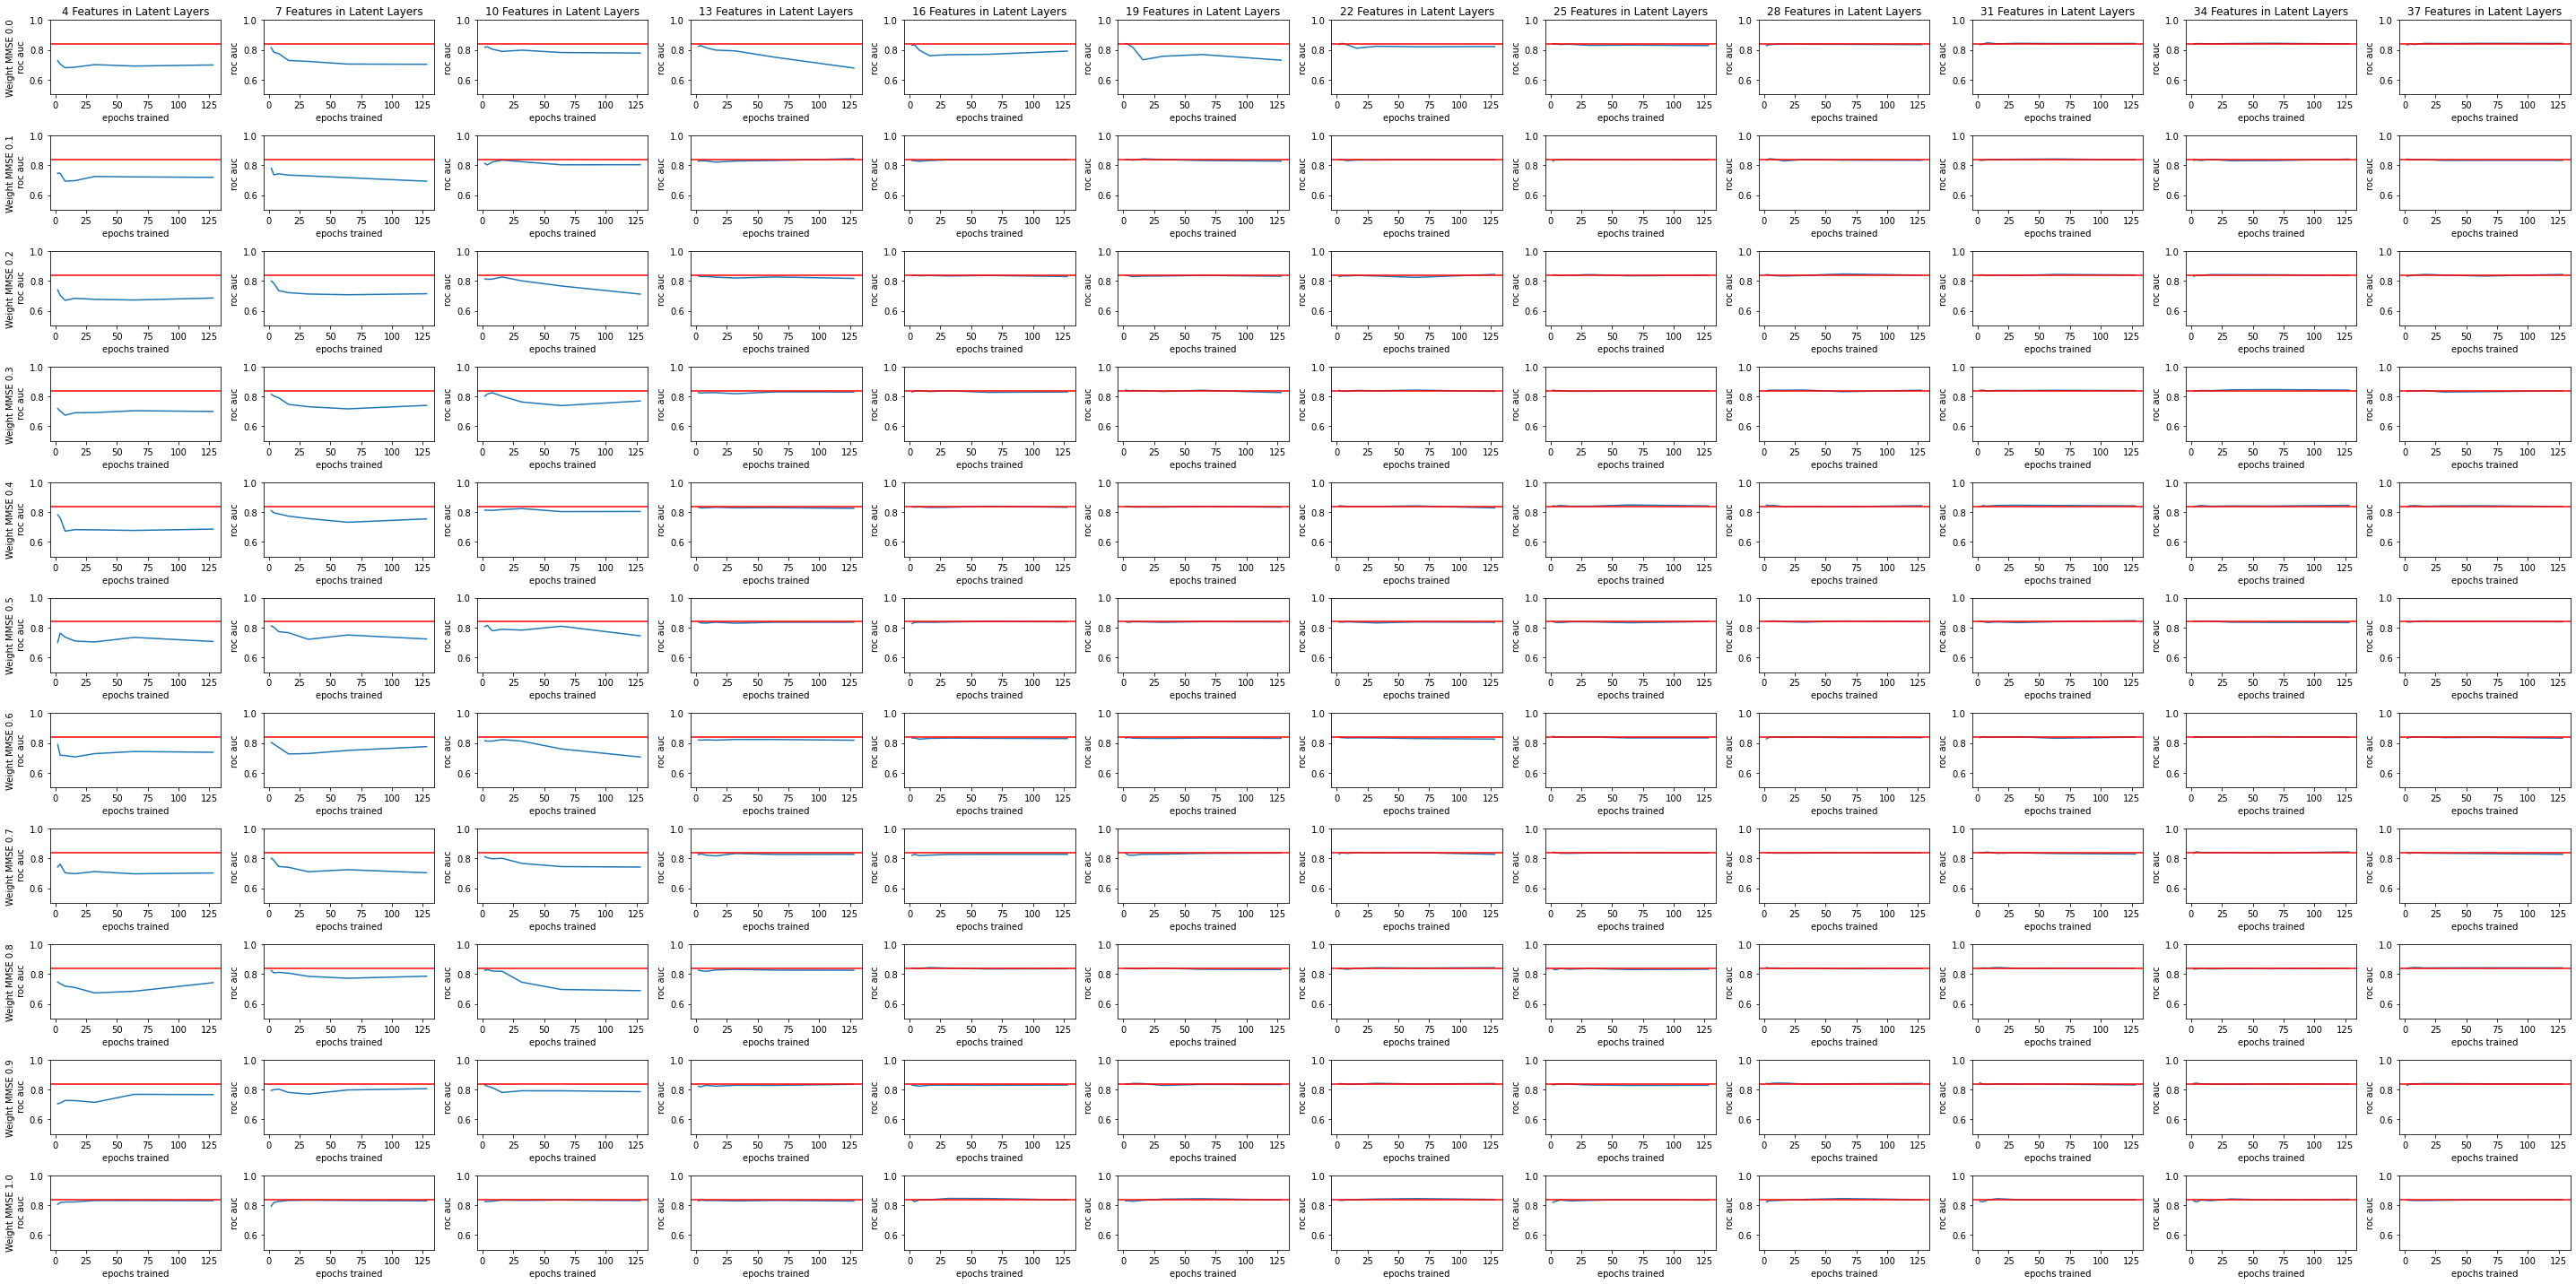

In [15]:
## -----------------------------------------------------------------------
## Loop through Autoencoder training and testing for a parameter
## -----------------------------------------------------------------------

weight_test = np.array(range(0, 11, 1)) / 10
epochs_test = [1] + list(range(1, 7, 1))
shape_test = np.array(range(4, 40, 3))
BATCH_SIZE = 2000
#EPOCHS = 10
LR = 1e-3

sampling_bias = dict()
sampling_bias_flat = []
roc_auc = dict()
roc_auc_flat = []

fig, axes = plt.subplots(nrows=len(weight_test), ncols=len(shape_test), figsize=(40, 20))

for weight in weight_test:
    sampling_bias[weight] = dict()
    roc_auc[weight] = dict()
    for layer in shape_test:
        
        start = timeit.default_timer()
        
        # Train Autoencoder
        LOSSFUNCWEIGHTS = [weight, 1 - weight, 0.0]  #[MMSE, KLDiv, MMD]

        dataset = aenc.CreditscoringDataset(datasetname)      # load and prepare Dataset to Tensor
        data_loader = aenc.DataLoader(                       # create Dataloader for batching
            dataset, 
            batch_size=BATCH_SIZE,
            shuffle=True,
            drop_last=True
        )

        shape = [dataset.x.shape[1], 45, layer, 45, dataset.x.shape[1]]  # define shape of Autoencoder PARAM = 25
        net3 = aenc.Autoencoder(shape)
        #print(net)
        net3.to("cpu")

        sampling_bias[weight][layer] = []
        roc_auc[weight][layer] = []

        prev_ep = 0
        for EPOCHS in epochs_test:

            train_loss, train_loss_mmse, train_loss_mmd, train_loss_kld = aenc.train(net3, data_loader, 2**EPOCHS, LR, LOSSFUNCWEIGHTS, verbose = False)

            # Simulate on encoded Data to measure sampling bias

            sim = dal.Simulate_acceptance_loop(datasetname, model, 0.1, 0.1, n_years, enc_features=True, encoder=net3)#, rej_inf=rinf.EMsemisupervised)
            results_generator = sim.run()

            metrics7 = None
            for iteration in results_generator:
                #print(f'Itteration: {iteration[0]}) Accepted: {iteration[1].count(True)} | Denied: {iteration[1].count(False)} - New train set size: {iteration[2]}')
                metrics7 = iteration[3]


            sampling_bias[weight][layer].append(h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics7["model"]["holdout"]['roc_auc'], last_n_years))
            roc_auc[weight][layer].append(sum(metrics7["model"]["holdout"]['roc_auc'][-last_n_years:]) / last_n_years)

            sampling_bias_flat.append(h.measure_bias(metrics["oracle"]["holdout"]['roc_auc'], metrics7["model"]["holdout"]['roc_auc'], last_n_years))
            roc_auc_flat.append(sum(metrics7["model"]["holdout"]['roc_auc'][-last_n_years:]) / last_n_years)

            print(f'PARAM: W({weight}), L({layer}), E({prev_ep + 2**EPOCHS}) | Sampling Bias: {round(sampling_bias[weight][layer][-1], 5)} // ROC-AUC: {round(roc_auc[weight][layer][-1], 5)}')

            prev_ep += 2**EPOCHS
        
        stop = timeit.default_timer()

        ## Update Plots after all EPOCHS are trained for a parameter combi
        epochs_values = np.cumsum(2**np.array(epochs_test))

        w = len(sampling_bias) - 1
        l = len(sampling_bias[weight]) - 1
        
        axes[w][l].plot(epochs_values, roc_auc[weight][layer], label = 'roc_auc') 
        axes[w][l].axhline(y = baseline_roc_auc, color = 'r', label = 'baseline roc-auc')
        axes[w][l].set_ylabel(f'Weight MMSE {weight_test[w]}\n roc auc') if l == 0 else axes[w][l].set_ylabel('roc auc')

        if w == 0: axes[w][l].set_title(f'{shape_test[l]} Features in Latent Layers')

        axes[w][l].set_xlabel("epochs trained")
        axes[w][l].set_ylim([0.5, 1.0])
        fig.tight_layout()

        display.clear_output(wait=True)
        display.display(fig)

        print(f'Saving current results... - Last iteration took {stop - start} sec.')
        pickle.dump(roc_auc, open('roc-auc_grid-result.p', 'wb'))
        pickle.dump(roc_auc_flat, open('roc-auc-flat_grid-result.p', 'wb'))

        pickle.dump(sampling_bias, open('sampling-bias-result.p', 'wb'))
        pickle.dump(sampling_bias_flat, open('sampling-bias-flat-result.p', 'wb'))


In [30]:
roc_auc_flat1 = pickle.load(open('roc-auc-flat_grid-result.p', 'rb'))
sampling_bias_flat1 = pickle.load(open('sampling-bias-flat-result.p', 'rb'))

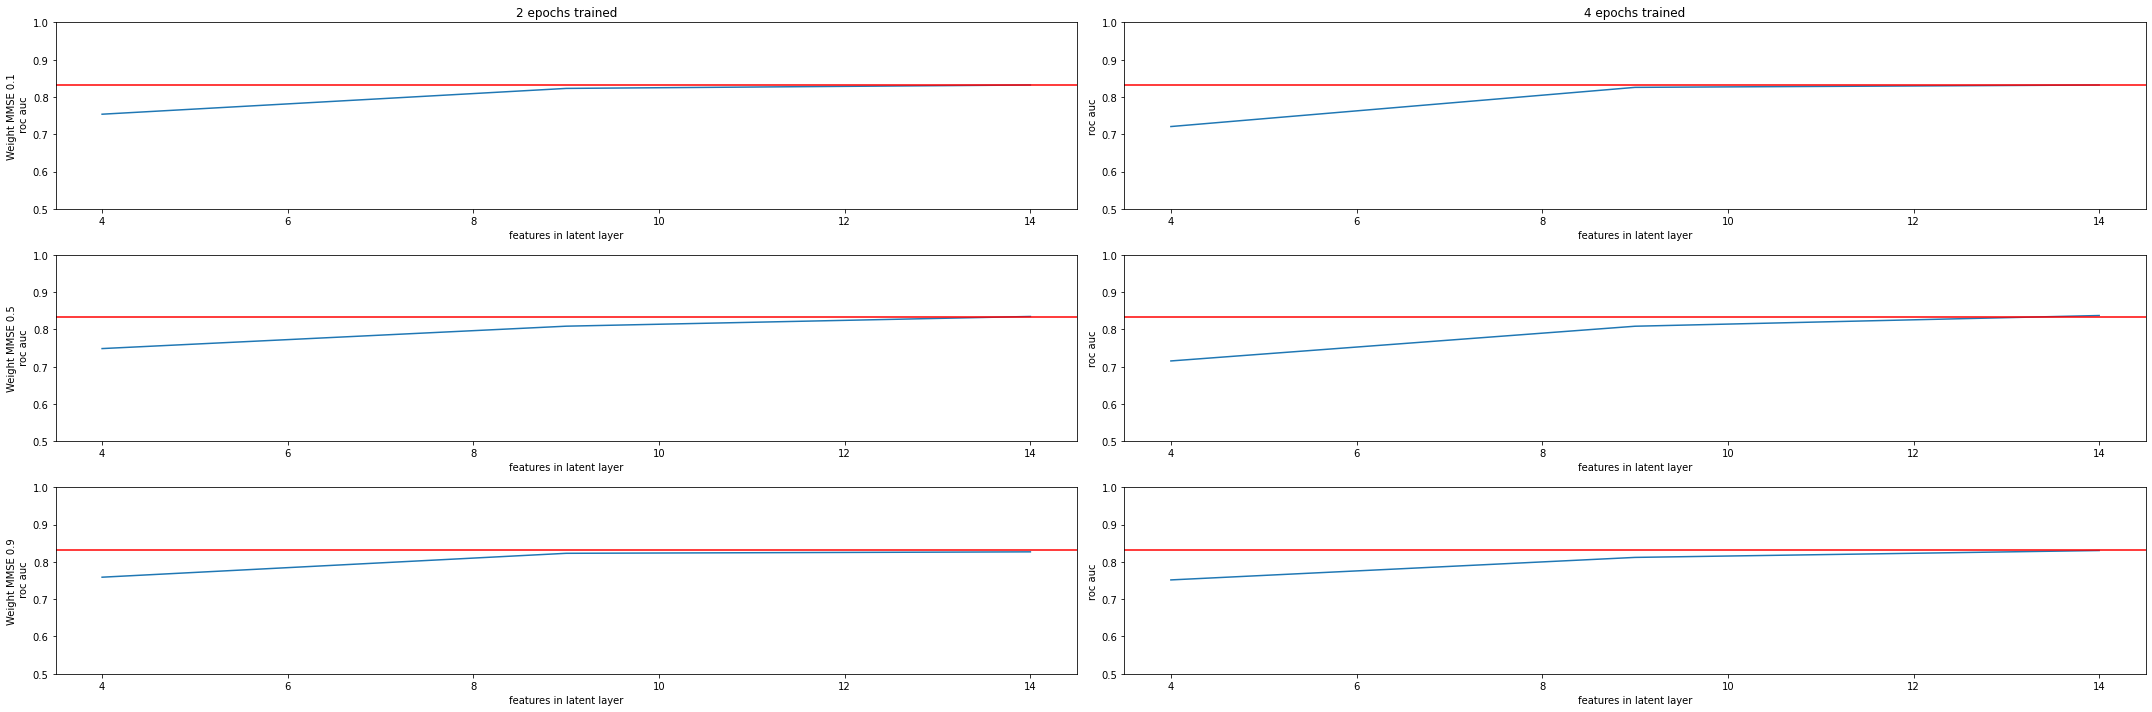

In [35]:
epochs_values = np.cumsum(2**np.array(epochs_test))

t_sampling_bias = torch.FloatTensor(sampling_bias_flat1).reshape(len(weight_test), len(shape_test), len(epochs_values))
t_roc_auc = torch.FloatTensor(roc_auc_flat1).reshape(len(weight_test), len(shape_test), len(epochs_values))

fig, axes = plt.subplots(nrows=weight_test.shape[0], ncols=epochs_values.shape[0], figsize=(30, 10))
for w in range(weight_test.shape[0]):
    for e in range(epochs_values.shape[0]):
        axes[w][e].plot(shape_test, t_roc_auc[w][:,e], label = 'roc_auc')
        axes[w][e].axhline(y = baseline_roc_auc, color = 'r', label = 'baseline roc-auc')
        axes[w][e].set_ylabel(f'Weight MMSE {weight_test[w]}\n roc auc') if e == 0 else axes[w][e].set_ylabel('roc auc')
        if w == 0: axes[w][e].set_title(f'{epochs_values[e]} epochs trained') 
        axes[w][e].set_xlabel("features in latent layer")
        axes[w][e].set_ylim([0.5, 1.0])
fig.tight_layout()